## ESPN fantasy basketball team analysis 🏀

Environment variables `ESPN_S2` and `ESPN_SWID` can be copied from the fantasy home (opened in browser) > application > cookies.

In [11]:
import os
from dotenv import load_dotenv
from espn_api.basketball import League

load_dotenv()
LEAGUE_NAME = os.getenv('LEAGUE_NAME')
LEAGUE = League(league_id=int(os.getenv('LEAGUE_ID')),
                year=int(os.getenv('YEAR')),
                espn_s2=os.getenv('ESPN_S2'),
                swid=os.getenv('ESPN_SWID'))


print(LEAGUE_NAME, 'teams', LEAGUE.teams)

Rozna Dolina association teams [Team(Lebron is my goat), Team(Marko's Magnificent Team), Team(Team Francetovi ), Team(Postojna Bevery Hills), Team(Rozna Dolina Tweakers), Team(Rozna dolina c2), Team(Drustvo telesne vadbe), Team(HalleLuka), Team(Sharks), Team(Kanta Team)]


## Script development

In [12]:
team = LEAGUE.teams[0]


print(team.team_name, 'roster', team.roster)

Lebron is my goat roster [Player(Cade Cunningham), Player(James Harden), Player(Jalen Johnson), Player(De'Aaron Fox), Player(Trey Murphy III), Player(Onyeka Okongwu), Player(Matas Buzelis), Player(Domantas Sabonis), Player(Tyler Herro), Player(Trae Young), Player(Scottie Barnes), Player(Derik Queen), Player(Jarrett Allen), Player(Kyrie Irving), Player(Julian Champagnie)]


In [13]:
PLAYER_CATEGORIES = ['FGA', 'FGM', 'FTA', 'FTM', '3PM', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS']

def get_player_stats(player):
    try:
        player_stats = player.stats[f"{os.getenv('YEAR')}_total"]['avg']
    except:
        print('Using projections for', player.name)
        player_stats = player.stats[f"{os.getenv('YEAR')}_projected"]['avg']
    
    player_stats = {cat: player_stats[cat] for cat in PLAYER_CATEGORIES}
    return player_stats


player = team.roster[0]
print(player.name, 'avg stats', get_player_stats(player))

Cade Cunningham avg stats {'FGA': 19.939393939393938, 'FGM': 9.272727272727273, 'FTA': 7.303030303030303, 'FTM': 6.121212121212121, '3PM': 2.0606060606060606, 'REB': 6.181818181818182, 'AST': 9.727272727272727, 'STL': 1.5454545454545454, 'BLK': 0.8181818181818182, 'TO': 3.9696969696969697, 'PTS': 26.727272727272727}


In [14]:
TEAM_CATEGORIES = ['FG%', 'FT%', '3PM', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS']

def get_team_stats(team):
    team_roster = [player for player in team.roster if player.lineupSlot != 'IR']
    team_stats = {cat: 0 for cat in PLAYER_CATEGORIES}
    for player in team_roster:
        player_stats = get_player_stats(player)
        for cat in PLAYER_CATEGORIES:
            team_stats[cat] += player_stats[cat]
    
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FT%'] = team_stats['FTM'] / team_stats['FTA']
    team_stats = {cat: team_stats[cat] for cat in TEAM_CATEGORIES}
    return team_stats


print(team.team_name, 'avg stats', get_team_stats(team))

Lebron is my goat avg stats {'FG%': 0.4808377018115759, 'FT%': 0.8358826142102664, '3PM': 23.1489817555607, 'REB': 81.64875788033683, 'AST': 65.18408250118776, 'STL': 14.986490129911184, 'BLK': 8.720472280998598, 'TO': 30.66498782156677, 'PTS': 247.77188013109068}


In [15]:
def get_league_stats():
    league_stats = {cat: 0 for cat in TEAM_CATEGORIES}
    n_teams = len(LEAGUE.teams)
    for team in LEAGUE.teams:
        team_stats = get_team_stats(team)
        for cat in TEAM_CATEGORIES:
            league_stats[cat] += team_stats[cat]
    
    for cat in TEAM_CATEGORIES:
        league_stats[cat] /= n_teams
    return league_stats


print(LEAGUE_NAME, 'avg stats', get_league_stats())

Rozna Dolina association avg stats {'FG%': 0.4831433976857766, 'FT%': 0.8060323593540414, '3PM': 23.142090680810153, 'REB': 73.84321235525309, 'AST': 51.69087067748965, 'STL': 13.561045290572224, 'BLK': 8.240098744130355, 'TO': 26.75215201526613, 'PTS': 231.15369844203457}


In [16]:
import math

def get_league_min():
    league_min = {cat: math.inf for cat in TEAM_CATEGORIES}
    for team in LEAGUE.teams:
        team_stats = get_team_stats(team)
        for cat in TEAM_CATEGORIES:
            league_min[cat] = min(league_min[cat], team_stats[cat])
    return league_min

def get_league_max():
    league_max = {cat: -math.inf for cat in TEAM_CATEGORIES}
    for team in LEAGUE.teams:
        team_stats = get_team_stats(team)
        for cat in TEAM_CATEGORIES:
            league_max[cat] = max(league_max[cat], team_stats[cat])
    return league_max


print(LEAGUE_NAME, 'min stats', get_league_min())
print(LEAGUE_NAME, 'max stats', get_league_max())

Rozna Dolina association min stats {'FG%': 0.4662022632429427, 'FT%': 0.744933752299582, '3PM': 15.929290073646195, 'REB': 59.802230658386605, 'AST': 33.468132128658446, 'STL': 10.173937279529385, 'BLK': 5.454915670664163, 'TO': 21.590125717099397, 'PTS': 208.1658134095634}
Rozna Dolina association max stats {'FG%': 0.5025039156455229, 'FT%': 0.8358826142102664, '3PM': 28.838706669977157, 'REB': 90.53642468741153, 'AST': 65.95717494693879, 'STL': 15.527563625415038, 'BLK': 12.744751708106971, 'TO': 31.185682273148977, 'PTS': 250.9956382077048}


## Min max normalization

https://en.wikipedia.org/wiki/Feature_scaling

In [17]:
def normalize_stats(stats, min, max):
    for cat in TEAM_CATEGORIES:
        stats[cat] = (stats[cat] - min[cat]) / (max[cat] - min[cat])
    return stats


print(team.team_name, 'normalized stats', normalize_stats(get_team_stats(team), get_league_min(), get_league_max()))

Lebron is my goat normalized stats {'FG%': 0.4031617736385184, 'FT%': 1.0, '3PM': 0.5592577811739722, 'REB': 0.7108215429797407, 'AST': 0.9762045176253686, 'STL': 0.8989332724126933, 'BLK': 0.4479602275773482, 'TO': 0.9457358780034564, 'PTS': 0.9247310001428257}


In [18]:
def get_team_delta(team):
    team_stats = get_team_stats(team)
    league_stats = get_league_stats()
    normalized_team_stats = normalize_stats(team_stats, get_league_min(), get_league_max())
    normalized_league_stats = normalize_stats(league_stats, get_league_min(), get_league_max())
    
    team_delta = {cat: normalized_team_stats[cat] - normalized_league_stats[cat] for cat in TEAM_CATEGORIES}
    return team_delta


print(team.team_name, 'stats delta', get_team_delta(team))

Lebron is my goat stats delta {'FG%': -0.0635149014328828, 'FT%': 0.3282092181157721, '3PM': 0.0005338021822385297, 'REB': 0.2539694230378159, 'AST': 0.4153157696633031, 'STL': 0.26625781241427826, 'BLK': 0.06589634312773268, 'TO': 0.407775805753942, 'PTS': 0.38800489535920946}


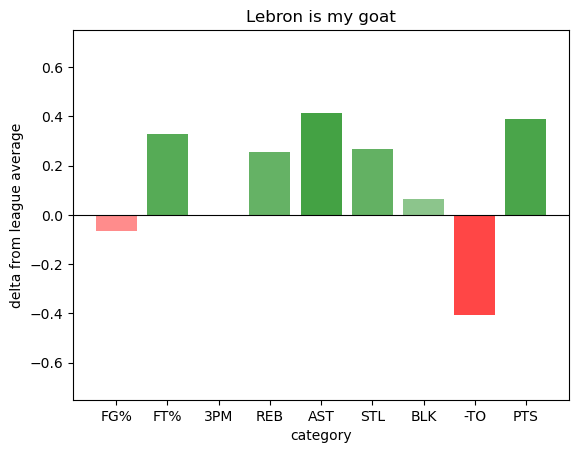

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DISPLAY_CATEGORIES = ['FG%', 'FT%', '3PM', 'REB', 'AST', 'STL', 'BLK', '-TO', 'PTS']


def calculate_alpha(value):
    return 0.4 + abs(value) * 0.8

def plot_team_delta(team):
    team_delta = get_team_delta(team)
    display_team_delta = {cat: 0 for cat in DISPLAY_CATEGORIES}
    for cat in DISPLAY_CATEGORIES:
        if cat == '-TO':
            display_team_delta[cat] = -team_delta['TO']
        else:
            display_team_delta[cat] = team_delta[cat]

    display_colors = []
    for cat in DISPLAY_CATEGORIES:
        delta = display_team_delta[cat]
        if delta > 0:
            display_colors.append(mcolors.to_rgba('green', calculate_alpha(delta)))
        else:
            display_colors.append(mcolors.to_rgba('red', calculate_alpha(delta)))

    plt.bar(display_team_delta.keys(), display_team_delta.values(), color=display_colors)
    plt.axhline(y=0, color='black', linewidth=0.8)
    plt.ylim(-0.75, 0.75)
    plt.title(team.team_name.strip())
    plt.xlabel('category')
    plt.ylabel('delta from league average')


plot_team_delta(team)
plt.show()

## Final results

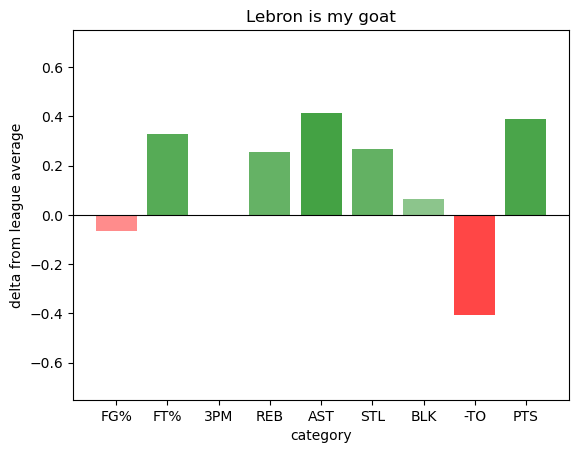

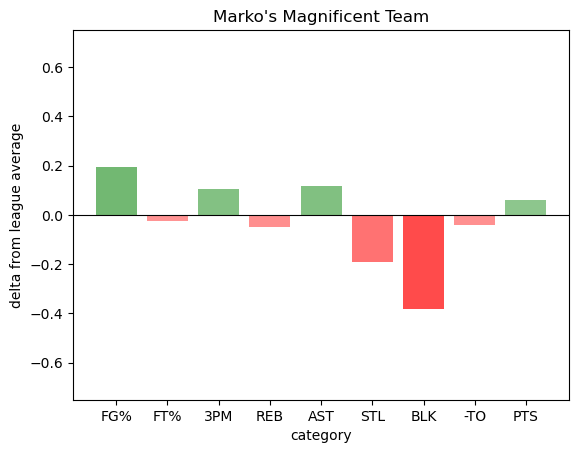

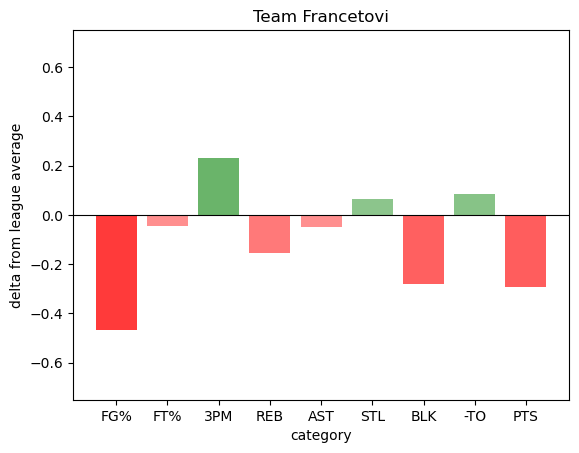

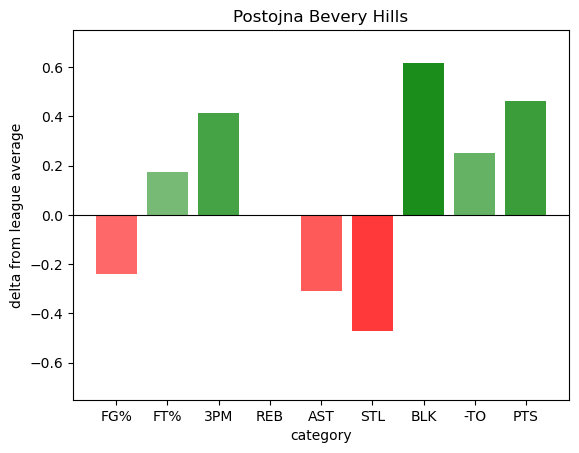

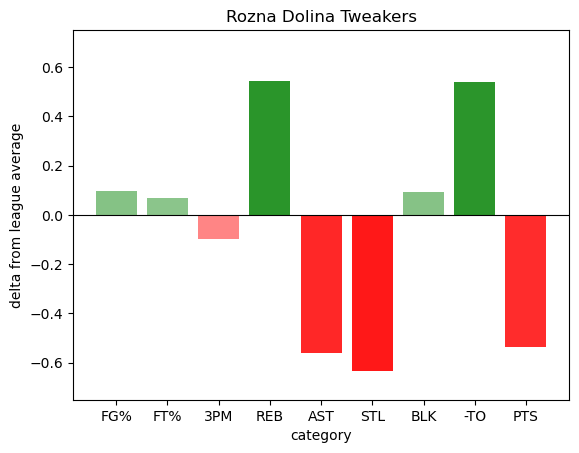

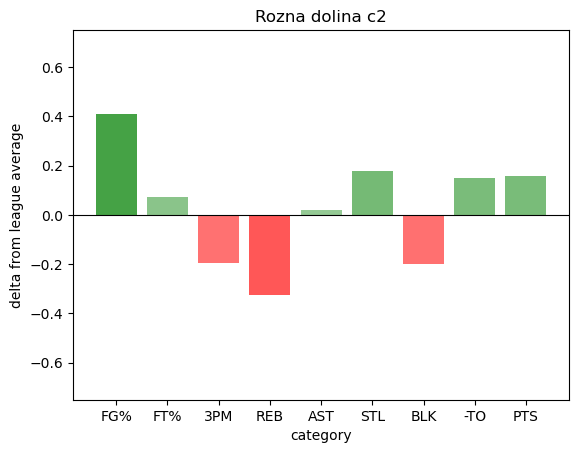

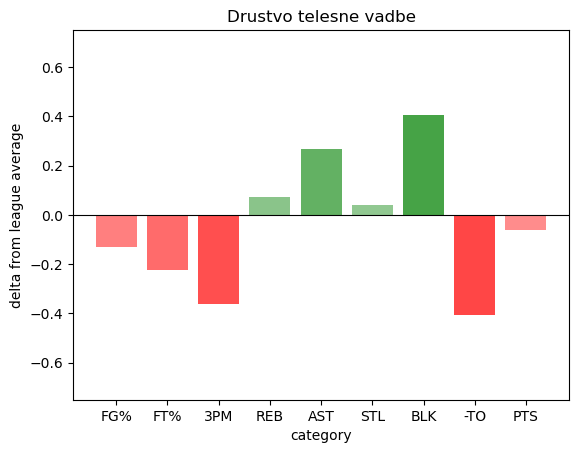

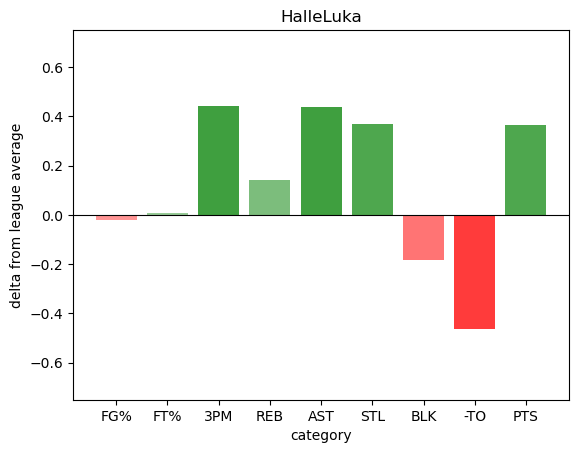

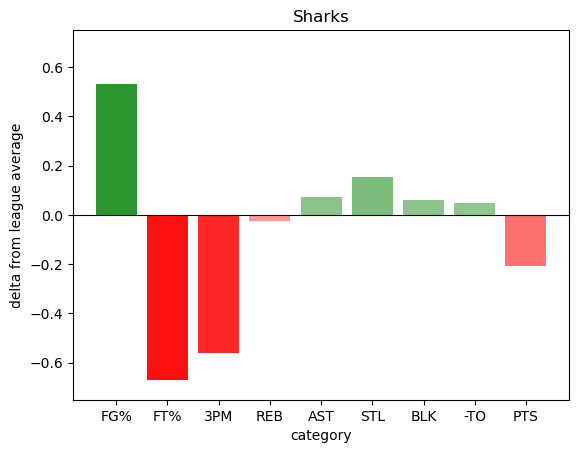

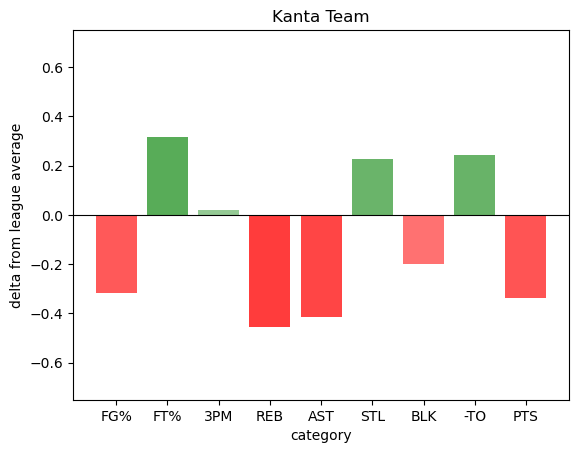

In [20]:
DIR_NAME = './out'


os.makedirs(DIR_NAME, exist_ok=True)
for team in LEAGUE.teams:
    plot_team_delta(team)
    file_name = team.team_name.strip() + '.png'
    file_path = os.path.join(DIR_NAME, file_name)

    plt.savefig(file_path)
    plt.show()